In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [3]:
from sklearn.datasets import make_blobs

In [4]:
from simple_ml.llms.llama3.model import MLP, Attention, LlamaConfig, RotaryEmbedding, LlamaModel, DecoderLayer
from simple_ml.tokenizers.bpe import BasicTokenizer

# Verify MLP

Load Iris data

In [5]:
X, y = make_blobs(n_samples=150, n_features=2)

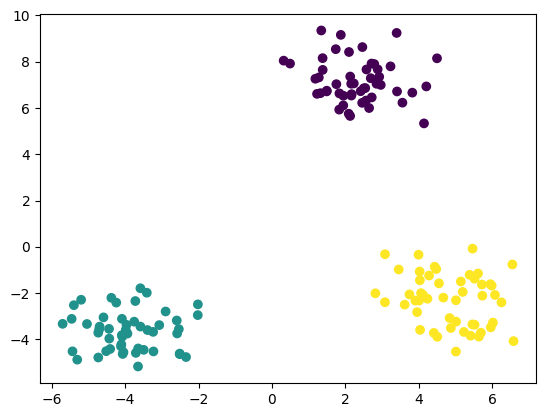

In [6]:
plt.scatter(X[:, 0], X[:, 1], c=y)

In [7]:
config = LlamaConfig(emb_hidden_size=128,
                     num_attn_heads=4, num_key_value_heads=2,
                     mlp_intermediate_size=20, num_layers=4, rope_base=10000,
                     vocab_size=64000)

In [8]:
class MLPWrapper(torch.nn.Module):
    def __init__(self, config, in_size=2, out_size=3):
        super().__init__()
        self.mlp = MLP(config)
        self.input_proj = torch.nn.Linear(in_size, config.emb_hidden_size)
        self.output_proj = torch.nn.Linear(config.emb_hidden_size, out_size)

    def forward(self, x):
        return self.output_proj(self.mlp(self.input_proj(x)))

In [9]:
mlp = MLPWrapper(config)

In [10]:
optimizer = torch.optim.AdamW(mlp.parameters(), lr=1e-3)

In [11]:
losses = []

for epoch in tqdm(range(50)):
    pred = mlp(torch.tensor(X).float())

    optimizer.zero_grad()

    pp = -torch.nn.LogSoftmax(dim=1)(pred)
    loss = pp.gather(1, torch.tensor(y)[:, None]).mean()

    loss.backward()
    optimizer.step()

    losses.append(loss.item())

  0%|          | 0/50 [00:00<?, ?it/s]

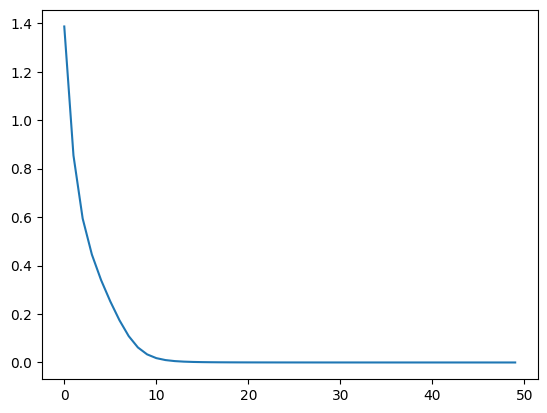

In [12]:
plt.plot(losses)

In [13]:
losses[-1]

3.2465399272041395e-05

# Verify attention 

In [14]:
# simple task: reverse a 6 character string

In [54]:
class AttentionWrapper(torch.nn.Module):
    def __init__(self, config: LlamaConfig):
        super().__init__()
        self.attention = Attention(config)
        self.rotary_embedding = RotaryEmbedding(base=10000, d=config.head_dim)
        self.token_embeds = torch.nn.Embedding(num_embeddings=config.vocab_size, embedding_dim=config.emb_hidden_size)

        self.lm_head = torch.nn.Linear(in_features=config.emb_hidden_size, out_features=config.vocab_size)

    def forward(self, token_ids, attention_mask):
        hidden_states = self.token_embeds(token_ids)

        cos, sin = self.rotary_embedding(token_ids)

        o = self.attention(hidden_states, attention_mask, (cos, sin))

        return self.lm_head(o)

In [16]:
def prepare_input(s):
    return f'{s} -> {s[::-1]}'

def create_dataset(n=1000, alphabet='abcdefghijklmnopqrstuvwxyz', d=2):
    out = []
    for _ in range(n):
        s = ''.join([alphabet[i] for i in np.random.randint(len(alphabet), size=np.random.randint(1, d+1))])
        out.append(prepare_input(s))
    return out

In [17]:
def compute_loss(seqs, model, tokenizer, device='cpu'):
    token_ids, attention_masks = tokenizer.encode_batch(seqs, padding_style='max_length')
    token_ids, attention_masks = torch.tensor(token_ids).to(device), torch.tensor(attention_masks).to(device)
    logits = model(token_ids, attention_masks)

    cel = torch.nn.CrossEntropyLoss(reduction='none') #, ignore_index=tokenizer.pad_token_id)
    losses = cel(logits[:, :-1].contiguous().view(-1, tokenizer.vocab_size), token_ids[:, 1:].contiguous().view(-1))
    masked_losses = losses * attention_masks[:, 1:].contiguous().view(-1)

    return masked_losses.sum() / attention_masks[:, 1:].sum()

In [18]:
def split_into_batches(l, b):
    n = len(l)
    n_batches = n // b + (0 if (n % b) == 0 else 1)
    
    return [l[i*b:(i+1)*b] for i in range(n_batches)]

In [19]:
def train_loop(seqs, optimizer, model, tokenizer, device='cpu'):
    b = 200
    seqs_batches = split_into_batches(seqs, b)

    losses = []
    for batch in seqs_batches:
        optimizer.zero_grad()
        loss = compute_loss(batch, model, tokenizer, device=device)
    
        loss.backward()
        optimizer.step()

        losses.append((loss.item(), len(batch)))

    return losses

In [27]:
def aggregate_losses(losses):
    num = 0
    denom = 0
    for l, n in losses:
        num += l * n
        denom += n

    return num / denom

In [68]:
seqs = create_dataset(n=20000, d=4)

In [69]:
tokenizer = BasicTokenizer(vocab_size=1000)
tokenizer.train(''.join(seqs))

config = LlamaConfig(emb_hidden_size=64,
                     num_attn_heads=4, num_key_value_heads=4,
                     mlp_intermediate_size=12000, num_layers=8, rope_base=10000,
                     vocab_size=tokenizer.vocab_size)

Training BPE:   0%|          | 0/740 [00:00<?, ?it/s]

In [70]:
model = LlamaModel(config)
atw = AttentionWrapper(config)

In [71]:
model = model.to('cuda')

In [72]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [73]:
losses = []

pbar = tqdm(range(500))
epoch_losses = []
for epoch in pbar:

    losses = train_loop(seqs, optimizer, model, tokenizer, device='cuda')

    epoch_losses.append(aggregate_losses(losses))
    pbar.set_postfix({'loss':epoch_losses[-1]})

  0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

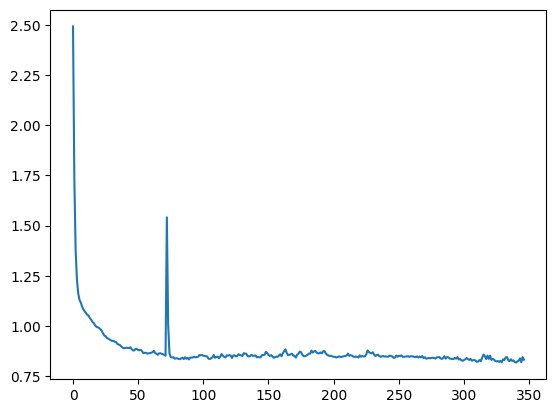

In [74]:
plt.plot(epoch_losses)

In [75]:
def generate(prompt, model, tokenizer, ntoks=10, device='cpu'):
    softmax = torch.nn.Softmax(dim=-1)

    token_ids, attention_masks = tokenizer.encode(f'<BOS>{prompt} -> ', add_special_tokens=False)
    token_ids, attention_masks = torch.tensor(token_ids)[None, :].to(device), torch.tensor(attention_masks)[None, :].to(device)


    for _ in range(ntoks):
        logits = model(token_ids, attention_masks)

        ids = logits[:, -1].argmax(dim=-1)

        attention_masks = torch.cat([attention_masks, torch.ones(1, 1).to(device)], dim=1)
        token_ids = torch.cat([token_ids, ids[None, :]], dim=1)

    # return token_ids
    return tokenizer.decode_batch(token_ids.cpu().detach().numpy().tolist(), skip_special_tokens=False)

In [76]:
generate('taxma', LlamaModel(config), tokenizer)

['<BOS>taxma -> -s\x1c):\x1cslld\x1c):\x1cdg�vaqf3Cs_']

In [77]:
seqs

['iwf -> fwi',
 'gpn -> npg',
 'dhse -> eshd',
 'wz -> zw',
 'u -> u',
 'plcj -> jclp',
 'awj -> jwa',
 'hk -> kh',
 'vm -> mv',
 'tqhx -> xhqt',
 'fhvb -> bvhf',
 'cohr -> rhoc',
 'ekm -> mke',
 'kxzc -> czxk',
 'p -> p',
 't -> t',
 'ub -> bu',
 'ybr -> rby',
 'yy -> yy',
 'y -> y',
 't -> t',
 'mp -> pm',
 'nxl -> lxn',
 'vmx -> xmv',
 'vokj -> jkov',
 'dqx -> xqd',
 'kdl -> ldk',
 'nor -> ron',
 'dcma -> amcd',
 'j -> j',
 'be -> eb',
 'snid -> dins',
 'gscz -> zcsg',
 'ba -> ab',
 'xook -> koox',
 'ytf -> fty',
 'y -> y',
 'ecik -> kice',
 'ikt -> tki',
 'y -> y',
 'pru -> urp',
 'cl -> lc',
 'bqn -> nqb',
 't -> t',
 'b -> b',
 'mqtc -> ctqm',
 'kas -> sak',
 'k -> k',
 'yzvu -> uvzy',
 'pkpu -> upkp',
 'm -> m',
 'rdo -> odr',
 'be -> eb',
 'kqoj -> joqk',
 'u -> u',
 'c -> c',
 'ia -> ai',
 'fr -> rf',
 'cho -> ohc',
 'jrp -> prj',
 'iq -> qi',
 'jsy -> ysj',
 'ufvm -> mvfu',
 'gy -> yg',
 'tt -> tt',
 'ork -> kro',
 'zrr -> rrz',
 'hbo -> obh',
 'ylh -> hly',
 'kn -> nk',
 'oj

In [84]:
generate('dsfoe', model, tokenizer, device='cuda')

['<BOS>dsfoe -> eofsd<EOS><EOS><EOS><EOS><EOS><EOS>']

In [438]:
tokenizer.encode('wpx')

([1, 123, 116, 124, 2], [1, 1, 1, 1, 1])

In [441]:
tokenizer.decode([1, 123, 116, 124, 2])

'wpx'

In [405]:
softmax = torch.nn.Softmax(dim=-1)

In [406]:
logits.shape

torch.Size([1, 11, 260])

In [407]:
tokenizer.decode((torch.where((softmax(logits)[0, -1] > 0.02))[0]).numpy().tolist())

'f'

tensor([106])

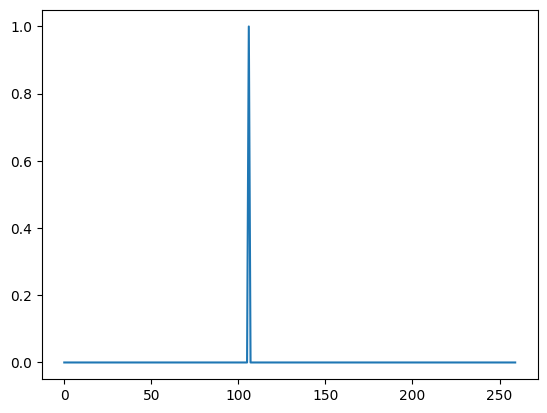

In [408]:
plt.plot(softmax(logits)[0, -1].detach())

In [402]:
logits[0, -1].argsort()

tensor([ 36, 124,   2, 117, 114,  66, 188,  48, 224,  45, 258,  86, 231,  59,
         80, 133, 252,  93, 228, 236,  69,  43, 196,  38, 189, 237,  97,  60,
         34,  76, 230,  10, 134,  11,  50, 221,  39, 180, 253, 248,  85, 187,
        142, 212, 226,  54,  89, 155, 219, 244, 140,  16,  84, 109,  27, 162,
          7,  98,  20, 161, 169, 209, 132,  82, 234, 232,  91, 163,  25,  52,
        200, 147,  79,  24,  22,  37, 170, 220,  14, 160, 153,  74, 179, 182,
         30,  87, 227,  78, 152,  15,   9, 157,  40, 216,  19,  81, 203, 144,
        207, 192, 198, 167, 214,  83,  72, 100, 246, 193, 135, 175,  32,  95,
          6, 225, 254, 233,  31,  35,  67, 166,  64, 241, 127,  12, 178, 240,
        205, 151, 222,  53, 158,  94,  70,  56,  68, 150, 186, 211, 138, 208,
         18, 130, 181, 159,  99, 259, 171, 176, 154,  73, 229, 250, 199, 247,
         88,  51,  44,  96,  47, 223, 257,  23, 215,  63, 195, 251,   3,  90,
        197, 255,  77,  21, 131, 129, 256, 184,   4,  42,  46,  

In [403]:
tokenizer.decode([105])

'e'

tensor([101])

']'

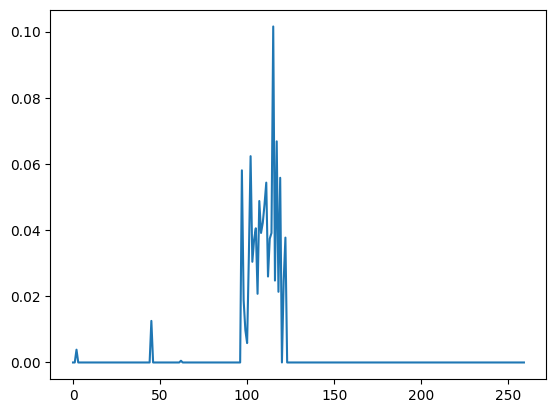

In [143]:
plt.plot(softmax(logits[:, -1])[0].detach())